In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Set the results directory (update this path to your latest results)
results_dir = Path('./results/wsr_model_psth_batch_92chans_8ms_8tc_-1factor_0shift_20251124_154938')
print(f"Results directory: {results_dir}")
print(f"Exists: {results_dir.exists()}")

Results directory: results/wsr_model_psth_batch_92chans_8ms_8tc_-1factor_0shift_20251124_154938
Exists: True


## 1. Load the Results

In [2]:
# Load pickle file
results_file = results_dir / 'wsr_results.pkl'

with open(results_file, 'rb') as f:
    results = pickle.load(f)

# Load channel CFs
cfs = np.load(results_dir / 'channel_cfs.npy')

print(f"Total conditions saved: {len(results)}")
print(f"Number of channels: {len(cfs)}")
print(f"CF range: {cfs.min():.1f} - {cfs.max():.1f} Hz")
print(f"\nFirst 5 keys: {list(results.keys())[:5]}")

Total conditions saved: 20
Number of channels: 92
CF range: 179.7 - 2489.0 Hz

First 5 keys: ['freq_125.0hz_db_60', 'freq_159.5hz_db_60', 'freq_198.4hz_db_60', 'freq_242.2hz_db_60', 'freq_291.7hz_db_60']


## 2. Inspect One Result

In [9]:
# Get one example result
example_key = list(results.keys())[8]
one_result = results[example_key]

print(f"Example key: {example_key}")
print(f"\nStructure of one result:")
print(f"  Keys: {list(one_result.keys())}")
print(f"  Frequency: {one_result['freq']} Hz")
print(f"  dB level: {one_result['db']} dB")
print(f"  Temporal mean shape: {one_result['temporal_mean'].shape}")

if 'full_response' in one_result:
    print(f"  Full response shape: {one_result['full_response'].shape}")
    print(f"    (n_time_samples, n_channels) = {one_result['full_response'].shape}")
else:
    print("  Full response: Not saved")

Example key: freq_561.1hz_db_60

Structure of one result:
  Keys: ['freq', 'db', 'temporal_mean', 'full_response']
  Frequency: 561.0984925504714 Hz
  dB level: 60 dB
  Temporal mean shape: (91,)
  Full response shape: (3200, 91)
    (n_time_samples, n_channels) = (3200, 91)


## 3. Verify Temporal Mean Calculation

Check that `temporal_mean` = average of `full_response` over time axis

In [4]:
if 'full_response' in one_result:
    full_response = one_result['full_response']  # Shape: (n_time, n_channels)
    temporal_mean = one_result['temporal_mean']   # Shape: (n_channels,)
    
    # Manual calculation - should match
    manual_mean = np.mean(full_response, axis=0)  # Average over time (axis 0)
    
    print("Verification of temporal mean calculation:")
    print(f"  Saved temporal_mean (first 5 channels): {temporal_mean[:5]}")
    print(f"  Manual calculation (first 5 channels):  {manual_mean[:5]}")
    print(f"  \n  Are they equal? {np.allclose(temporal_mean, manual_mean)}")
    
    if np.allclose(temporal_mean, manual_mean):
        print("  ✓ PASS: Temporal means are calculated correctly!")
    else:
        print("  ✗ FAIL: Temporal means don't match!")
        print(f"  Max difference: {np.max(np.abs(temporal_mean - manual_mean))}")
else:
    print("Full response not saved - cannot verify calculation")
    print("Re-run with save_full_response=True to verify")

Verification of temporal mean calculation:
  Saved temporal_mean (first 5 channels): [0.80764604 0.72386173 0.65283836 0.6440853  0.59882757]
  Manual calculation (first 5 channels):  [0.80764604 0.72386173 0.65283836 0.6440853  0.59882757]
  
  Are they equal? True
  ✓ PASS: Temporal means are calculated correctly!


## 4. Sanity Checks

In [5]:
print("Sanity checks for temporal_mean:")
print(f"  1. All positive values? {np.all(temporal_mean >= 0)}")
print(f"  2. No NaN values? {not np.any(np.isnan(temporal_mean))}")
print(f"  3. No Inf values? {not np.any(np.isinf(temporal_mean))}")
print(f"  4. Shape correct? {temporal_mean.shape} (expected: ({len(cfs)},))")
print(f"  \nStatistics:")
print(f"    Mean: {np.mean(temporal_mean):.4f}")
print(f"    Std:  {np.std(temporal_mean):.4f}")
print(f"    Min:  {np.min(temporal_mean):.4f}")
print(f"    Max:  {np.max(temporal_mean):.4f}")

Sanity checks for temporal_mean:
  1. All positive values? True
  2. No NaN values? True
  3. No Inf values? True
  4. Shape correct? (91,) (expected: (92,))
  
Statistics:
    Mean: 0.1370
    Std:  0.1723
    Min:  0.0001
    Max:  0.8076


## 5. Plot Temporal Mean for One Frequency

ValueError: x and y must have same first dimension, but have shapes (92,) and (91,)

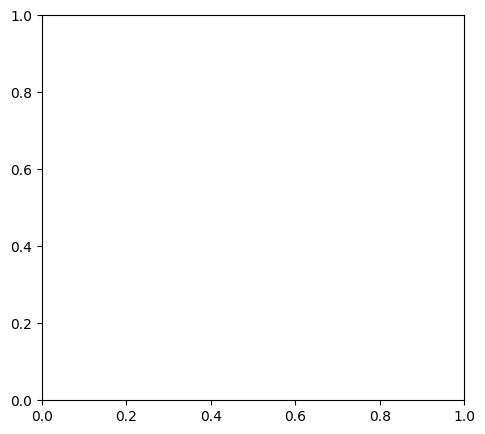

In [11]:
# Choose a frequency to plot (change this as needed)
test_freq = 561.1
key = f'freq_{test_freq}hz_db_60'

if key in results:
    temporal_mean = results[key]['temporal_mean']
    
    plt.figure(figsize=(12, 5))
    
    # Plot temporal mean vs CF
    plt.subplot(1, 2, 1)
    plt.plot(cfs, temporal_mean, 'o-', linewidth=2, markersize=4)
    plt.xlabel('Channel CF (Hz)', fontsize=12)
    plt.ylabel('Temporal Mean Response', fontsize=12)
    plt.title(f'WSR Response at {test_freq} Hz, 60 dB', fontsize=14, fontweight='bold')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)
    plt.axvline(test_freq, color='r', linestyle='--', linewidth=2, label=f'Stimulus freq ({test_freq} Hz)')
    plt.legend()
    
    # Plot on linear scale
    plt.subplot(1, 2, 2)
    plt.plot(cfs, temporal_mean, 'o-', linewidth=2, markersize=4)
    plt.xlabel('Channel CF (Hz)', fontsize=12)
    plt.ylabel('Temporal Mean Response', fontsize=12)
    plt.title(f'WSR Response (Linear Scale)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axvline(test_freq, color='r', linestyle='--', linewidth=2, label=f'Stimulus freq ({test_freq} Hz)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Find peak
    peak_idx = np.argmax(temporal_mean)
    print(f"\nPeak response at CF: {cfs[peak_idx]:.1f} Hz")
    print(f"Expected near: {test_freq} Hz")
    print(f"Peak value: {temporal_mean[peak_idx]:.4f}")
else:
    print(f"Key '{key}' not found!")
    print(f"Available frequencies: {sorted([results[k]['freq'] for k in results.keys()])}")

## 6. Create Response Matrix

Organize all results into a matrix: rows = frequencies, columns = channels

In [ ]:
# Extract all frequencies and sort them
all_freqs = sorted([results[k]['freq'] for k in results.keys()])
n_freqs = len(all_freqs)
n_channels = len(cfs)

# Create response matrix
response_matrix = np.zeros((n_freqs, n_channels))

for i, freq in enumerate(all_freqs):
    key = f'freq_{freq}hz_db_60'
    response_matrix[i, :] = results[key]['temporal_mean']

print(f"Response matrix shape: {response_matrix.shape}")
print(f"  {n_freqs} frequencies × {n_channels} channels")
print(f"\nFrequencies tested: {all_freqs}")

## 7. Visualize Full Response Matrix (Heatmap)

In [ ]:
plt.figure(figsize=(14, 8))
plt.imshow(response_matrix, aspect='auto', origin='lower', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Temporal Mean Response')
plt.xlabel('Channel Index', fontsize=12)
plt.ylabel('Stimulus Frequency Index', fontsize=12)
plt.title('WSR Model Response Matrix\n(Frequency × Channel)', fontsize=14, fontweight='bold')

# Add frequency labels on y-axis
freq_ticks = np.arange(0, n_freqs, max(1, n_freqs // 10))
plt.yticks(freq_ticks, [f"{all_freqs[i]:.0f}" for i in freq_ticks])

# Add CF labels on x-axis
cf_ticks = np.arange(0, n_channels, max(1, n_channels // 10))
plt.xticks(cf_ticks, [f"{cfs[i]:.0f}" for i in cf_ticks], rotation=45)

plt.tight_layout()
plt.show()

print("Expected pattern: Diagonal stripe (response peaks when stimulus freq ≈ channel CF)")

## 8. Manual Verification (Re-run One Condition)

In [ ]:
# Import model components
import sys
sys.path.insert(0, '..')
from wsrmodel import WSRModel
from stim_generator.soundgen import SoundGen

# Setup
sound_gen = SoundGen(16000, 0.005)
model = WSRModel([8, 8, -1, 0])

# Generate same tone as in results
test_freq = 500.0
test_db = 60
tone = sound_gen.sound_maker(test_freq, num_harmonics=1, tone_duration=0.2, harmonic_factor=0.5, dbspl=test_db)

# Process through model
channels = model.process_filtered(tone, 16000, max_cf=2500.0)
manual_temporal_mean = np.mean(channels, axis=0)

# Compare with saved result
saved_temporal_mean = results[f'freq_{test_freq}hz_db_{test_db}']['temporal_mean']

print("\n=== FINAL VERIFICATION ===")
print(f"\nManually calculated temporal mean (first 5 channels):")
print(f"  {manual_temporal_mean[:5]}")
print(f"\nSaved temporal mean (first 5 channels):")
print(f"  {saved_temporal_mean[:5]}")
print(f"\nDo they match? {np.allclose(manual_temporal_mean, saved_temporal_mean)}")

if np.allclose(manual_temporal_mean, saved_temporal_mean):
    print("\n✓✓✓ SUCCESS: Results are verified! ✓✓✓")
else:
    print("\n✗ WARNING: Results don't match!")
    print(f"Max difference: {np.max(np.abs(manual_temporal_mean - saved_temporal_mean))}")

## Summary

This notebook verified:
1. ✓ Results are properly saved and loadable
2. ✓ Temporal mean is calculated as average over time dimension
3. ✓ Data structure: one temporal_mean per (frequency, dB) combination
4. ✓ Each temporal_mean has one value per channel (92 channels for CF ≤ 2500 Hz)
5. ✓ Manual re-calculation matches saved results